In [1]:
from amftrack.pipeline.functions.transport_processing.high_mag_videos.kymo_class import *
from amftrack.pipeline.functions.transport_processing.high_mag_videos.plot_data import (
    save_raw_data,
    plot_summary
)
# from amftrack.pipeline.development.high_mag_videos.high_mag_videos_fun import segment_brightfield
import os
import imageio.v2 as imageio
import matplotlib.pyplot as plt
import cv2
import numpy as np
from tifffile import imwrite
from tifffile import imread
from tqdm import tqdm
%matplotlib widget
%load_ext autoreload
%autoreload 2
from amftrack.pipeline.functions.image_processing.extract_graph import (
    from_sparse_to_graph,
    generate_nx_graph,
    clean_degree_4,
)
import scipy
from pathlib import Path
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
from scipy.optimize import minimize_scalar
from skimage.filters import try_all_threshold
from skimage.filters import threshold_yen

/gpfs/home6/svstaalduine/AMF_project/amftrack/util/dbx.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
2024-01-12 16:36:50.869779: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-12 16:36:51.170561: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /gpfs/home6/svstaalduine/.local/lib/python3.9/site-packages/cv2/../../lib64:/sw/arch/Centos8/EB_production/2021/software/ZeroMQ/4.3.4-GCCcore-10.3.0/lib:

In [39]:


def calculate_renyi_entropy(threshold, pixels):
    # Calculate probabilities and entropies
    Ps = np.mean(pixels <= threshold)
    Hs = -np.sum(pixels[pixels <= threshold] * np.log(pixels[pixels <= threshold] + 1e-10))
    Hn = -np.sum(pixels * np.log(pixels + 1e-10))

    # Calculate phi(s)
    phi_s = np.log(Ps * (1 - Ps)) + Hs / Ps + (Hn - Hs) / (1 - Ps)

    return -phi_s

def RenyiEntropy_thresholding(image):
    # Flatten the image
    pixels = image.flatten()
#     print(pixels)
    # Find the optimal threshold
    initial_threshold = np.mean(pixels)
    result = minimize_scalar(calculate_renyi_entropy, bounds=(0, 255), args=(pixels,), method='bounded')
    
    optimal_threshold = result.x
#     print(optimal_threshold)
#     print(np.max(image))
    _, thresholded = cv2.threshold(image/np.max(image)*255, optimal_threshold, 255, cv2.THRESH_BINARY)

    return thresholded


def segment_brightfield(image, thresh=0.5e-6, frangi_range=np.arange(70, 170, 30), seg_thresh = 11, binning=2):
    frangi_range = frangi_range * 2 / binning
    smooth_im_blur = cv2.blur(-image, (11, 11))
    smooth_im = frangi(-smooth_im_blur, frangi_range)
    smooth_im = np.array(smooth_im * (255/np.max(smooth_im)), dtype=np.uint8)
    seg_shape = smooth_im.shape

#     for i in range(1, 100):
#         _, segmented = cv2.threshold(smooth_im, i, 255, cv2.THRESH_BINARY)
#         coverage = 100 * np.sum(1 * segmented.flatten()) / (255 * seg_shape[0] * seg_shape[1])
#         if coverage < seg_thresh:
#             break
    return smooth_im

def segment_fluo(image, thresh=0.5e-7, seg_thresh=4.5, k_size=40, magnif=50, binning=2, test_plot=False):
    k_size = [30, 5][magnif < 50]
    kernel = np.ones((k_size, k_size), np.uint8)
    kernel_2 = np.ones((10, 10), np.uint8)
    smooth_im = cv2.GaussianBlur(image, (5, 5), 0)
#     smooth_im = cv2.morphologyEx(smooth_im, cv2.MORPH_TOPHAT, kernel)
#     im_canny_smooth = cv2.GaussianBlur(im_canny, (5, 5), 0)
    smooth_im_close = cv2.morphologyEx(smooth_im, cv2.MORPH_OPEN, kernel)
    std_im = generic_filter(image, np.std, size=60)
    if magnif < 30:
        im_canny = cv2.Canny(smooth_im, 0, 20)
        smooth_im = cv2.morphologyEx(im_canny, cv2.MORPH_DILATE, kernel)



#     criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.85)
#     retval, labels, centers = cv2.kmeans(k_data, [4, 2][magnif < 30], None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
#     centers = np.uint8(centers)
#     labels = np.array(labels.T[0])
#     centers = [center[0] for center in centers]
#     segmented_data = np.array([centers[label] for label in labels])
#     segmented_image = segmented_data.reshape((smooth_im.shape))
#     segmented_image = np.uint8(segmented_image > np.min(centers))
#     segmented = cv2.morphologyEx(segmented_image, cv2.MORPH_CLOSE, kernel_2)

#     skeletonized = skeletonize(segmented > thresh)

#     if test_plot:
#         fig, ax = plt.subplots(7, figsize=(9, 25))
#         ax[0].imshow(im_canny)
#         ax[0].set_title("Smooth")
#         ax[1].imshow(std_im)
#         ax[1].set_title("open")
#         ax[2].imshow(smooth_im)
#         ax[2].set_title("smooth_im")
#         ax[3].imshow(segmented)
#         ax[3].set_title("segmented")
#         ax[4].imshow(skeletonized)
#         ax[5].hist(smooth_im_close.flatten(), log=True, bins=50)
#         ax[6].plot(smooth_im_close[1000])
#         fig.tight_layout()

#     skeleton = scipy.sparse.dok_matrix(skeletonized)
#     nx_graph, pos = generate_nx_graph(from_sparse_to_graph(skeleton))
#     nx_graph_pruned, pos = remove_spurs(nx_graph, pos, threshold=200)
    return smooth_im, smooth_im_close, std_im

# def segm_std(frames, magnification=50, binning=2):
    
def segment_brightfield_std(
    images,
    seg_thresh=1.05,
):
    """
    Segmentation method for brightfield video, uses vesselness filters to get result.
    image:          Input image
    thresh:         Value close to zero such that the function will output a boolean array
    frangi_range:   Range of values to use a frangi filter with. Frangi filter is very good for brightfield vessel segmentation

    """
    std_image = np.std(images,axis=0)/np.mean(images,axis=0)
    smooth_im_blur = cv2.blur(std_image, (101, 101))
    print(np.max(std_image))
    print(np.max(smooth_im_blur))
    
    
#     plt.figure(2)
#     plt.imshow(smooth_im_blur)
    
#     plt.figure(3)
#     plt.imshow(std_image)
    
    

    

#     fig, ax = try_all_threshold(smooth_im_blur, figsize=(10, 8), verbose=False)
#     plt.show()
    # this works well, the other yen implementation doesn't work yet. not worth to try myself when this works well already
    thresh = threshold_yen(smooth_im_blur)
    # the renyi entropy works now aswell.
    # It is weird that we calculate with an image [0,1] and rescale to [0,255] for thresholding
    segmented = RenyiEntropy_thresholding(smooth_im_blur)
    segmented2 = (smooth_im_blur >= thresh * seg_thresh).astype(np.uint8) * 255

    skeletonized = skeletonize(segmented > 0)

    skeleton = scipy.sparse.dok_matrix(skeletonized)
    nx_graph, pos = generate_nx_graph(from_sparse_to_graph(skeleton))
    nx_graph_pruned, pos = remove_spurs(nx_graph, pos, threshold=200)

    return (segmented, nx_graph_pruned, pos, segmented2)   

vid_folder = Path("/gpfs/scratch1/shared/amftrackflow/videos/CocoTransport/")
plate = "20230906_Plate310"
vid_interest = "003"
# edge_interest = "edge (115, 104)"
img_address = vid_folder / plate / vid_interest 
# img_address = vid_folder


print(img_address)

/gpfs/scratch1/shared/amftrackflow/videos/CocoTransport/20230906_Plate310/003


In [36]:
def calculate_yen_threshold(pixels):
    hist, bins = np.histogram(pixels, bins=256, range=[0,256], density=True)
    hist_cumsum = hist.cumsum()

    threshold = np.argmax(hist_cumsum * (1 - hist_cumsum))
    return threshold

def yen_threshold(image):
    pixels = image.flatten()
#     print(pixels)
    optimal_threshold = calculate_yen_threshold(pixels)
#     print(optimal_threshold)
    _, thresholded = cv2.threshold(image, optimal_threshold, 255, cv2.THRESH_BINARY)

    return thresholded

In [4]:
def find_histogram_edge(image,plot=False):
    # Calculate the histogram
    hist, bins = np.histogram(image.flatten(), 40)
    hist = hist.astype(float) / hist.max()  # Normalize the histogram

    # Sobel Kernel
    sobel_kernel = np.array([-1, 0, 1])

    # Apply Sobel edge detection to the histogram
    sobel_hist = convolve(hist, sobel_kernel)

    # Find the point with the highest gradient change
    threshold = np.argmax(sobel_hist)

    # Optional: Plot the results
    if plot:
        plt.figure(figsize=(10, 5))

        # Plot the original histogram
        plt.subplot(1, 2, 1)
        plt.plot(hist)
        plt.axvline(x=threshold, color='r', linestyle='--')

        plt.title("Histogram")

        # Plot the Sobel histogram
        plt.subplot(1, 2, 2)
        plt.plot(sobel_hist)
        plt.title("Sobel Histogram")
        plt.axvline(x=threshold, color='r', linestyle='--')

        plt.show()

    return bins[threshold]

[PosixPath('/gpfs/scratch1/shared/amftrackflow/videos/CocoTransport/20230906_Plate310/003/Img/Img_00000.tif'), PosixPath('/gpfs/scratch1/shared/amftrackflow/videos/CocoTransport/20230906_Plate310/003/Img/Img_00001.tif'), PosixPath('/gpfs/scratch1/shared/amftrackflow/videos/CocoTransport/20230906_Plate310/003/Img/Img_00002.tif'), PosixPath('/gpfs/scratch1/shared/amftrackflow/videos/CocoTransport/20230906_Plate310/003/Img/Img_00003.tif'), PosixPath('/gpfs/scratch1/shared/amftrackflow/videos/CocoTransport/20230906_Plate310/003/Img/Img_00004.tif'), PosixPath('/gpfs/scratch1/shared/amftrackflow/videos/CocoTransport/20230906_Plate310/003/Img/Img_00005.tif'), PosixPath('/gpfs/scratch1/shared/amftrackflow/videos/CocoTransport/20230906_Plate310/003/Img/Img_00006.tif'), PosixPath('/gpfs/scratch1/shared/amftrackflow/videos/CocoTransport/20230906_Plate310/003/Img/Img_00007.tif'), PosixPath('/gpfs/scratch1/shared/amftrackflow/videos/CocoTransport/20230906_Plate310/003/Img/Img_00008.tif'), PosixPath

100%|█████████████████████████████████████████████████████████████████████████████████| 192/192 [00:08<00:00, 21.34it/s]

CPU times: user 1.2 s, sys: 464 ms, total: 1.67 s
Wall time: 9.12 s


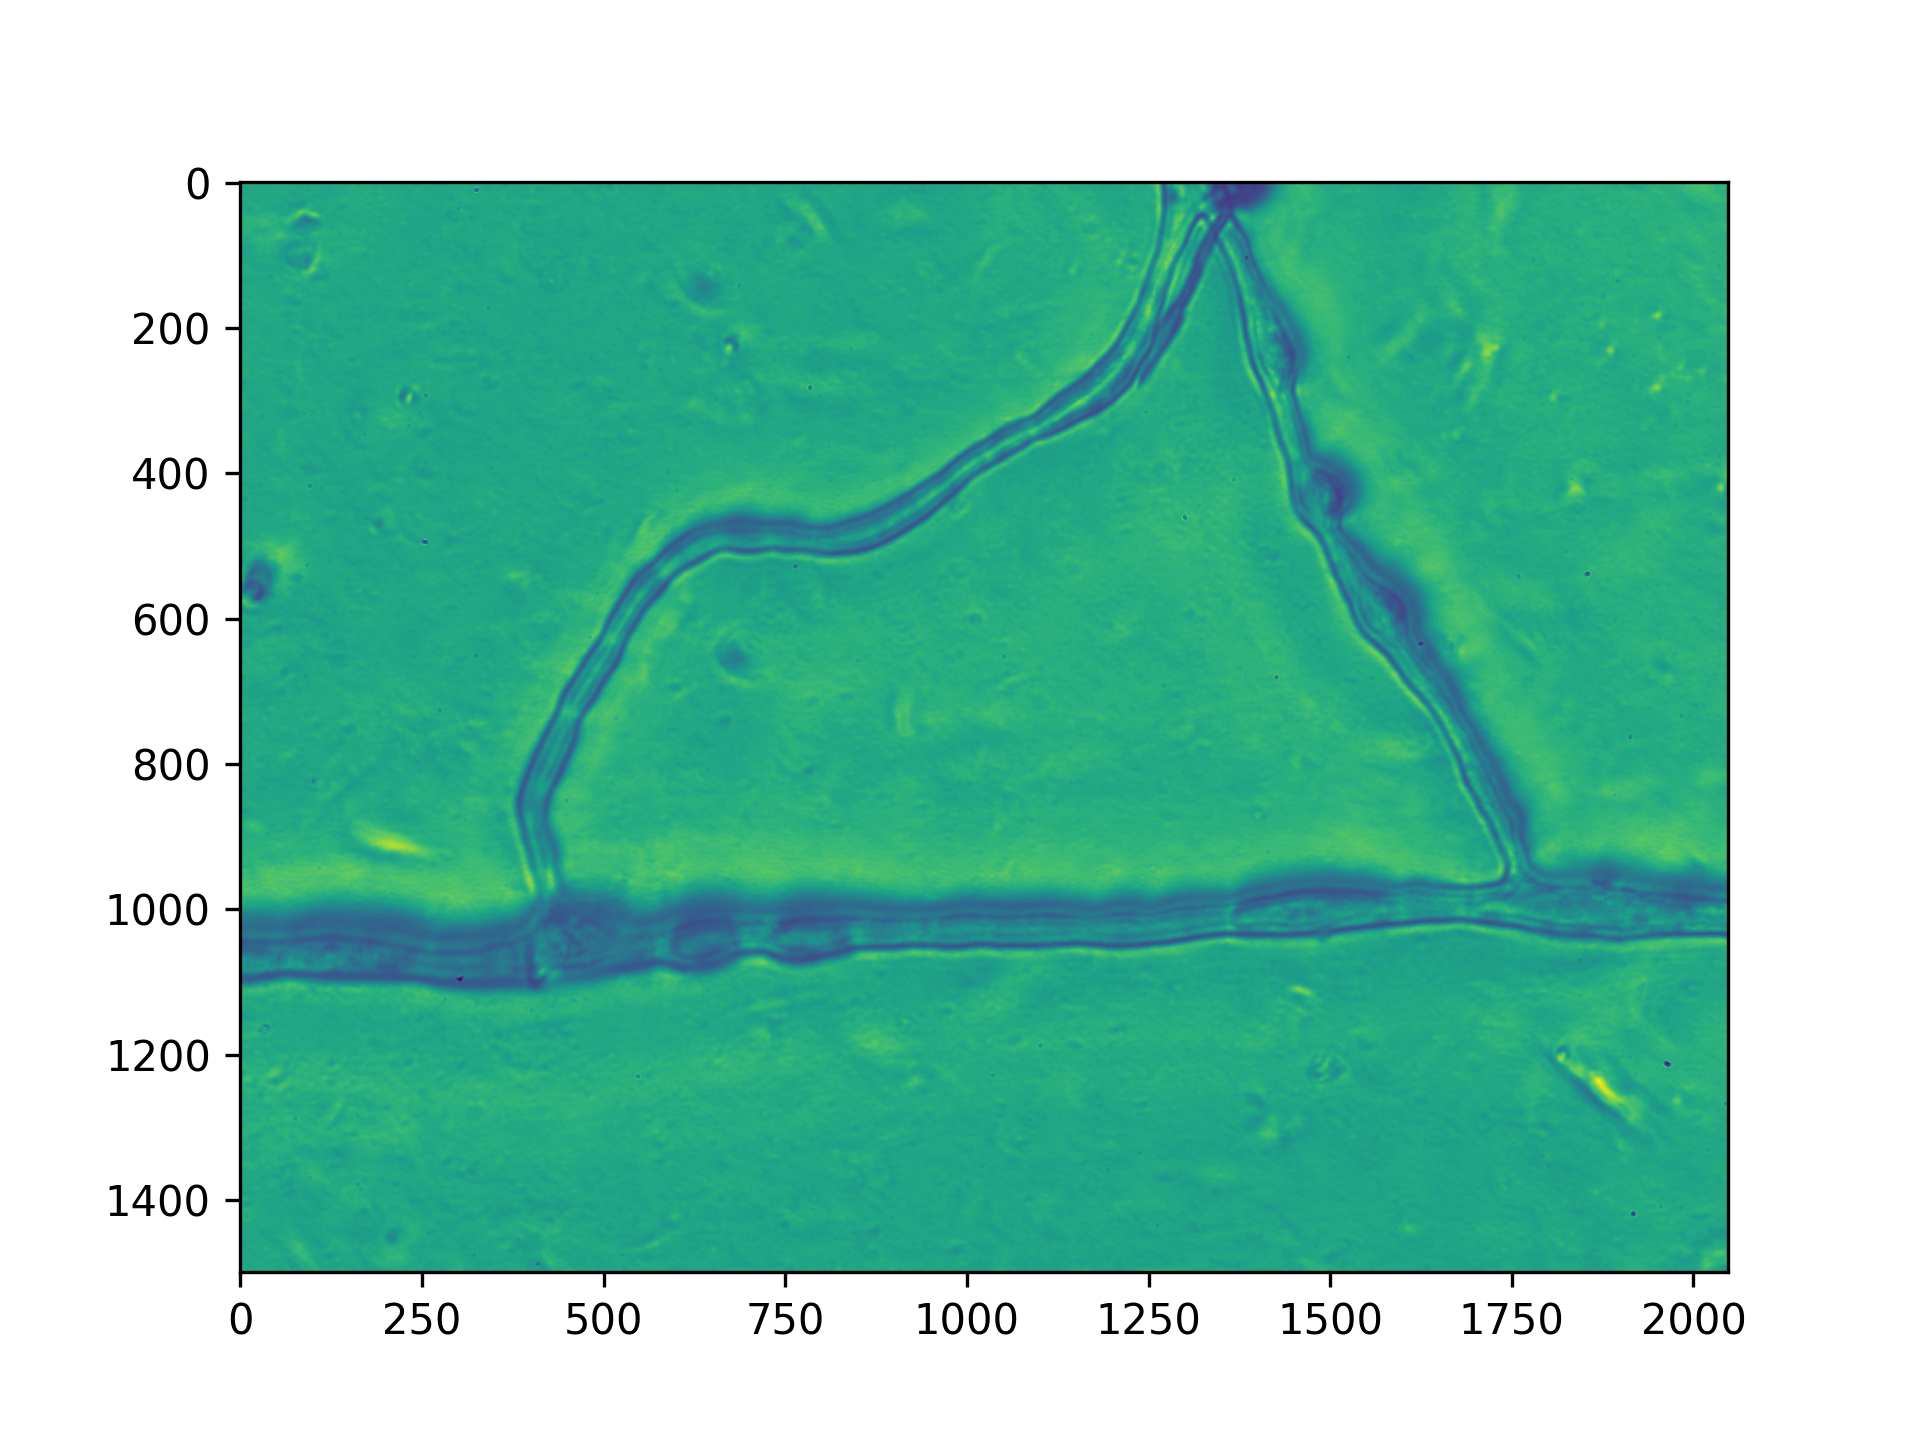

In [11]:
%%time

imgs = sorted([path for path in img_address.glob("*/*.ti*")])
print(imgs)
frames = []
frame_max = imread(imgs[0])
for address in tqdm(imgs):
    frame2 = imread(address)
    
    if (len(frames) < 600):
        frames.append(frame2)
        
    frame_max = np.maximum(frame_max, frame2)
img = frame_max


fig, ax = plt.subplots()
ax.imshow(img)

0.16756257368306993
0.07094832766436435
[0.01523352 0.01523231 0.01523453 ... 0.01531247 0.01531325 0.01531468]


/scratch-local/svstaalduine/ipykernel_3580176/1719488167.py:8: RuntimeWarning: divide by zero encountered in log
  phi_s = np.log(Ps * (1 - Ps)) + Hs / Ps + (Hn - Hs) / (1 - Ps)
/scratch-local/svstaalduine/ipykernel_3580176/1719488167.py:8: RuntimeWarning: invalid value encountered in double_scalars
  phi_s = np.log(Ps * (1 - Ps)) + Hs / Ps + (Hn - Hs) / (1 - Ps)


97.4013328687768
0.07094832766436435


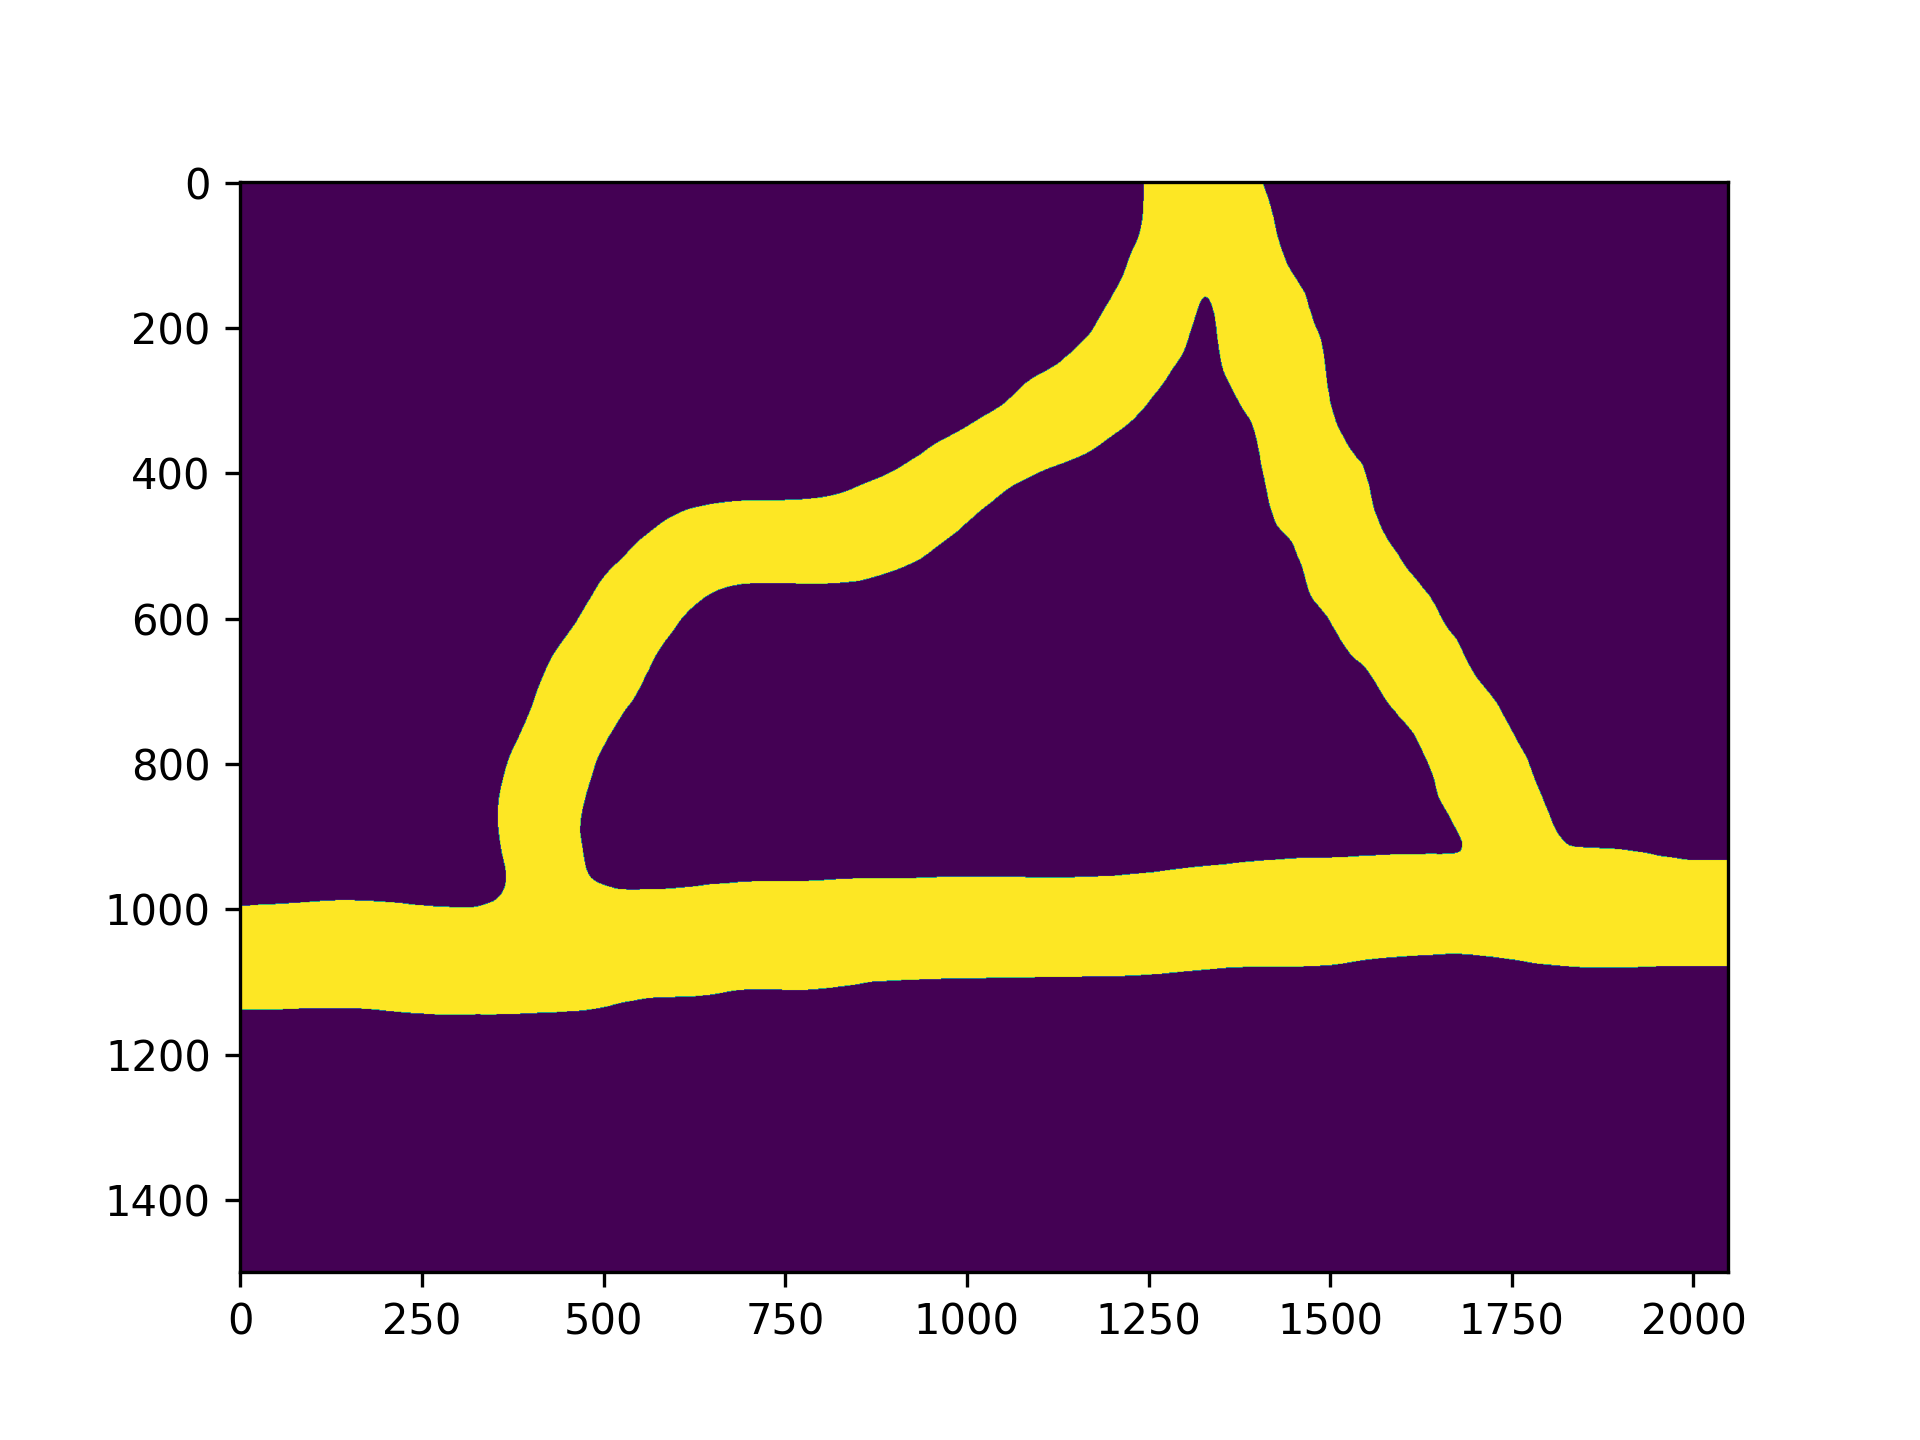

CPU times: user 1min 5s, sys: 22.7 s, total: 1min 27s
Wall time: 1min 32s


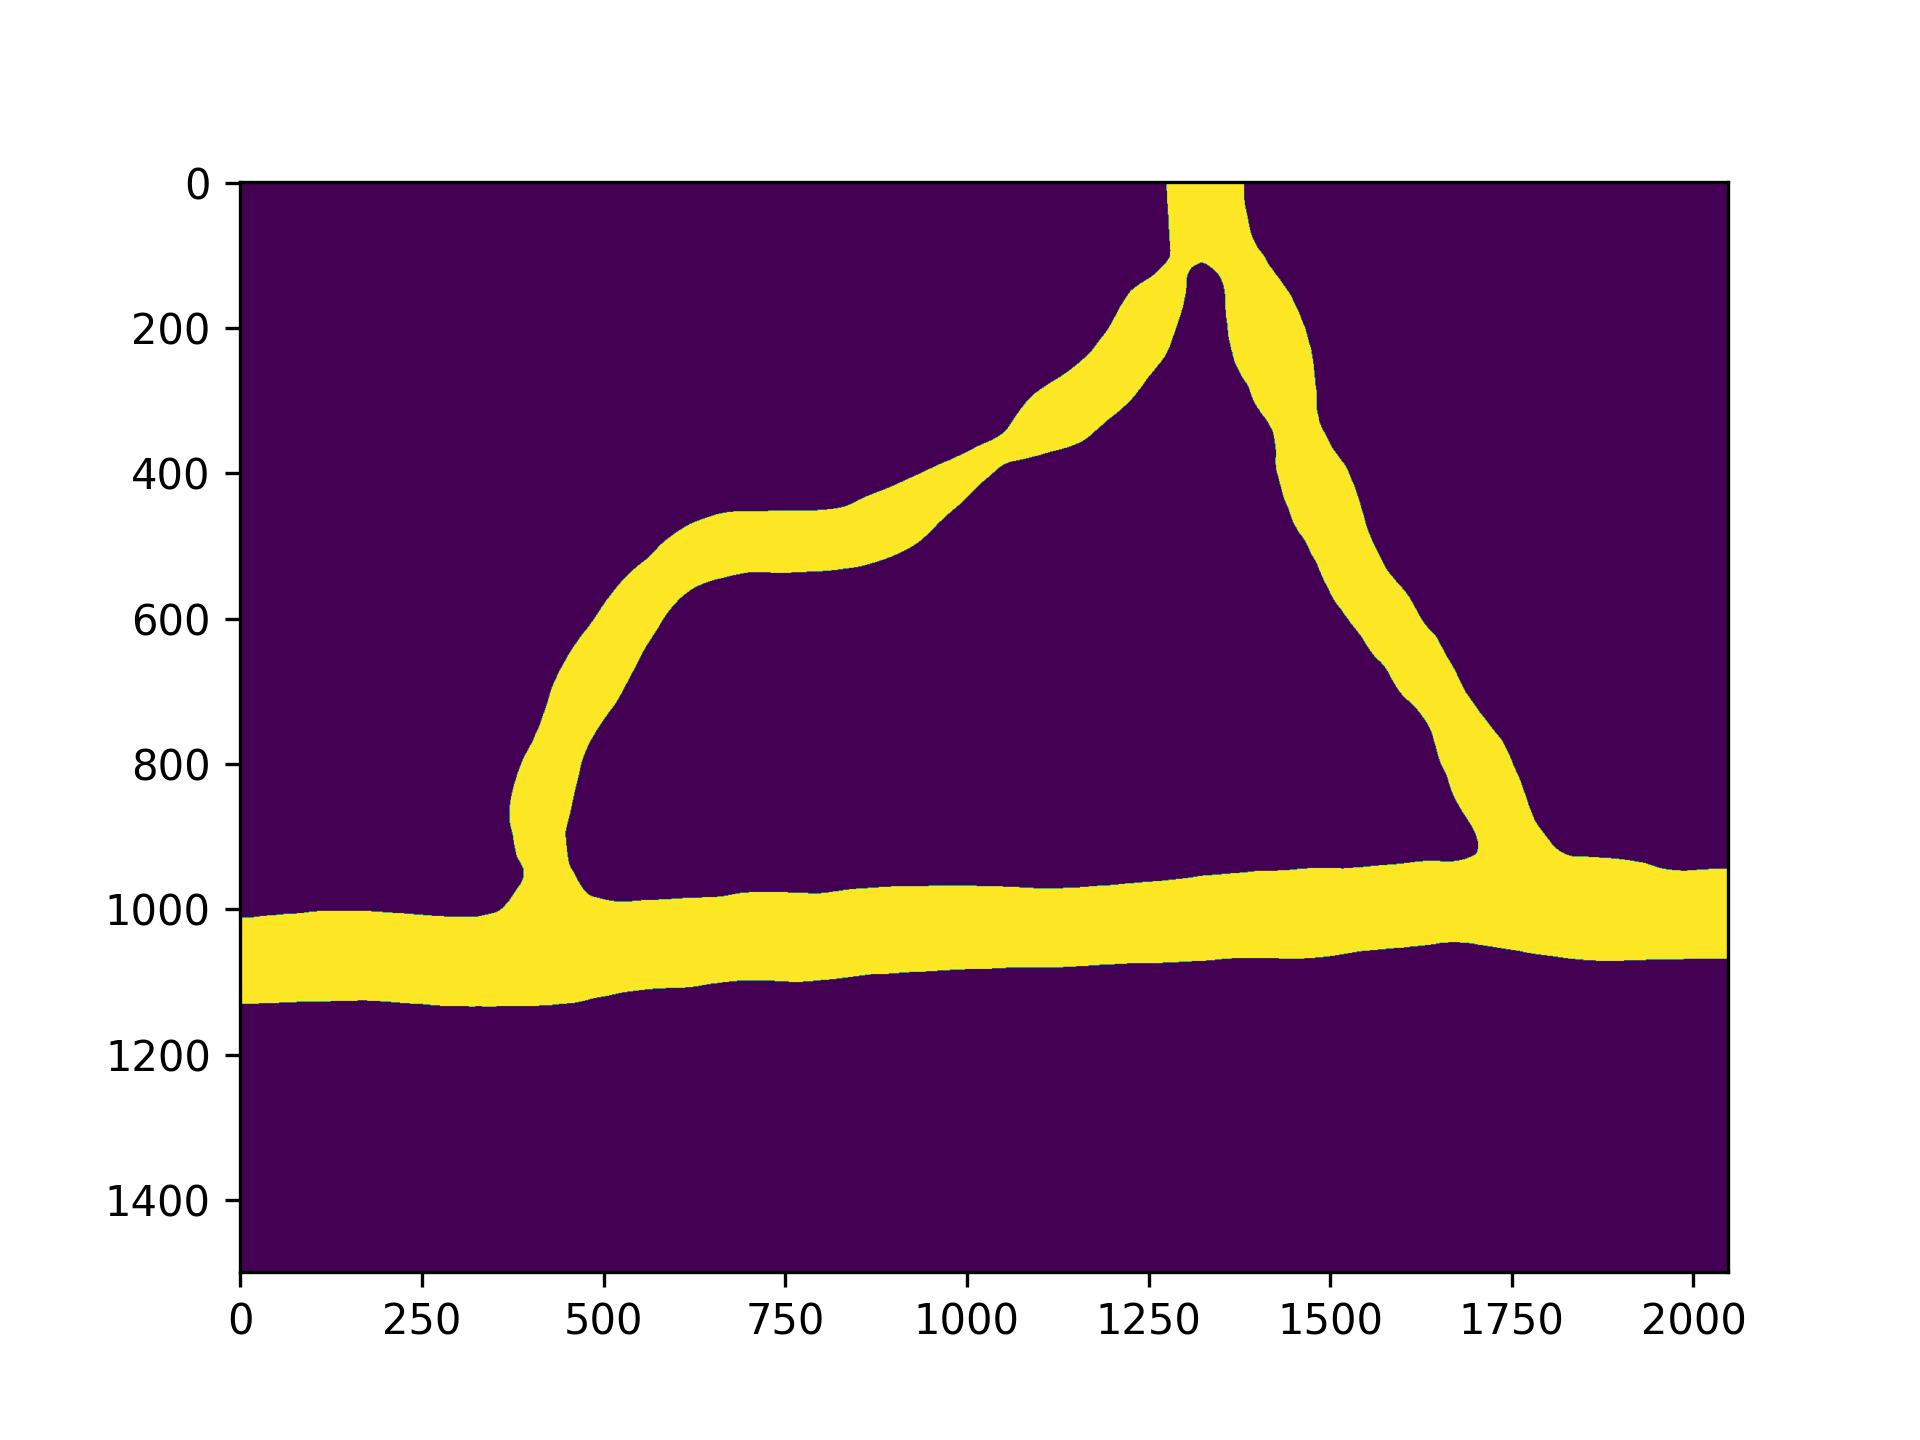

In [40]:
%%time

plt.close('all')
segmented_std, nx_graph_pruned, posi, segmented2 = segment_brightfield_std(frames)

plt.figure(1)
plt.imshow(segmented_std)

plt.figure(2)
plt.imshow(segmented2)
plt.show()

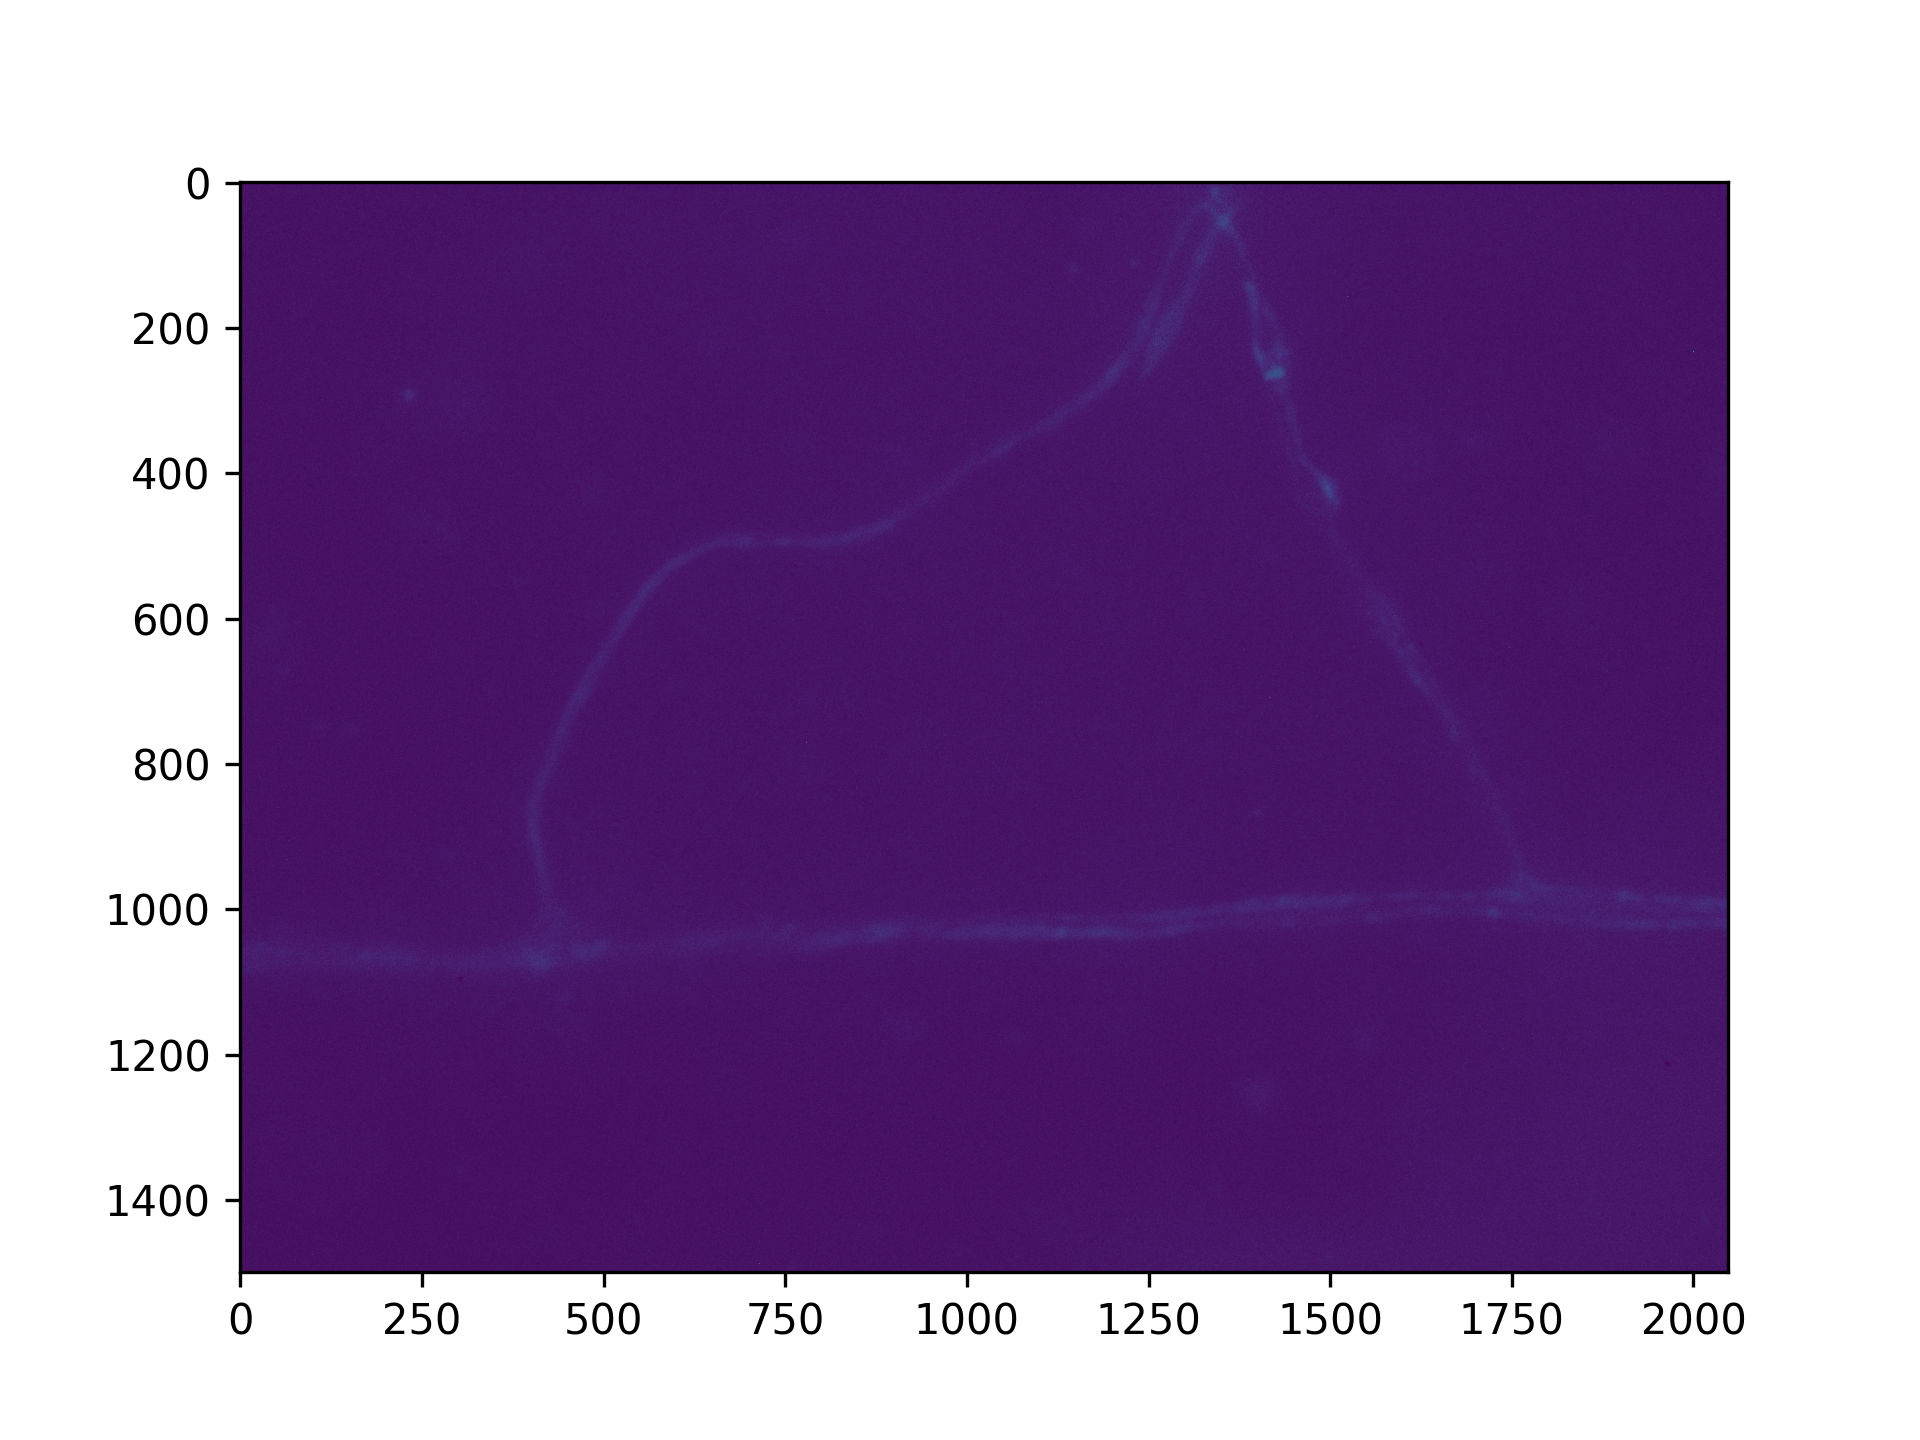

In [18]:
video_matrix = np.stack(frames, axis=0)

std_matrix = np.std(video_matrix, axis=0)

plt.imshow(std_matrix, cmap='viridis')
plt.show()

In [ ]:
from skimage.filters import try_all_threshold

img = data.page()

fig, ax = try_all_threshold(img, figsize=(10, 8), verbose=False)
plt.show()

In [ ]:


# Path to the TIFF video
video_path = str(img_address)

# Open the video file
cap = cv2.VideoCapture(video_path)

# Initialize a list to store frames
frames = []

# Read the first five frames and store them in the frames list
frame_count = 0
while frame_count < 5:
    ret, frame = cap.read()
    if not ret:
        print("empty")
        # If the video has fewer than 5 frames, break out of the loop
        break
    frames.append(frame)
    frame_count += 1

print(frame_count)

# Convert the list of frames into a numpy array
video_matrix = np.stack(frames, axis=0)

# video_matrix now contains the first five frames as a 3D numpy array
# You can access individual frames using video_matrix[index], where index is 0 to 4.

std_matrix = np.std(video_matrix)



# Release the video capture object
cap.release()


In [ ]:
# segmented = segment_brightfield(img, frangi_range = np.arange(5, 40, 3))
# segmented = segment_brightfield(img, frangi_range = np.arange(10, 150, 20))
segmented, segment_alt, std_im = segment_fluo(img, magnif=50)
# _, segment_thresh = cv2.threshold(segment_alt, 0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

# segmented, segment_alt = segment_fluo(img, magnif=50)

_, segment_thresh = cv2.threshold(std_im, 0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
segment_thresh = cv2.morphologyEx(segment_thresh, cv2.MORPH_CLOSE, np.ones((9,9)))

fig, ax = plt.subplots(2, 2, figsize=(10, 5))
ax[0][0].imshow(img)
ax[0][1].imshow(segmented)
ax[1][0].imshow(segment_thresh)
ax[1][1].imshow(segment_alt)
fig.tight_layout()

# fig, ax = plt.subplots()
# ax.hist(segmented.flatten())

In [ ]:
ftimage = np.fft.fft2(img)
ftimage = np.fft.fftshift(ftimage)

fig, ax = plt.subplots()
ax.imshow(np.log(abs(ftimage.real)))